**to do** should consider adding PCA highest variance features to the oveall features in a second part

In [5]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def load_data(filename, selected_features="all"):
#     should probably do two in one ... load only those columns we need? idk
    data = pd.read_csv(filename, encoding="unicode_escape")
    if selected_features is not "all":
        return data[selected_features]
    else:
        return data
    
    
def get_column_type(data, n_cont_threshold=6):
    types = pd.DataFrame([[data.columns[idx], data[val].nunique()] for idx, val in enumerate(data)],
                        columns = ["features", "unique_values"])
    numerical = list(types[types["unique_values"]>n_cont_threshold]["features"])
    categorical = list(types[(types["unique_values"]<n_cont_threshold)&(types["unique_values"]>2)]["features"])
    binary = list(types[types["unique_values"]==2]["features"])
    return numerical, categorical, binary


def get_column_type_from_list(data_instance, numerical, categorical, binary):
    if str(data_instance) in numerical:
        return "num"
    elif str(data_instance) in categorical:
        return "cat"
    elif str(data_instance) in binary:
        return "bin"
    else:
        return None
    

def get_data_description(data, info, numerical, categorical, binary):
    description = pd.DataFrame([[data.columns[idx],
                           data[val].nunique(),
                           data[val].isnull().sum(),
                           data[val].isnull().sum()/len(data[val]),
                           data[val].min(),
                           data[val].max(),
                           list(data[val].value_counts(normalize=False).values)] for idx, val in enumerate(data.columns)],
                         columns = ["name", "nunique", "nnull","%null","min","max","counts"])
    
    description = pd.merge(description, info.drop(["format"], axis=1), on = "name" , how="left")
#     not sure its great to pass extra arguments inside the apply 100 times...
    description["type"] = description["name"].apply(lambda x: get_column_type_from_list(x, numerical, categorical, binary))
    description["ratio"] = description[description["type"]=="bin"].apply(lambda x: x["counts"][0]/x["counts"][1] if x["counts"][1]>0 else None,
                                                                                                                    axis= 1)
    return description

def remove_nullpoints_from_feature(data, feature):
    return data[~data[feature].isnull()]

load data

In [52]:
main_filename = "../data/epoct_ezvir_05dec2018_unlabeled_Jan.csv"
labels_filename = "../data/alge_data/epoct_ezvir_05dec2018_dictionary.csv"
selected_features = ["date_season_meteo",
           "dem_age_int",
           "dem_sex",
            "lab_malaria_any_d0",
            "signv_temp_d0",
            "symp_abdopain",
            "symp_cough",
            "symp_fev24h",
            "symp_vomit",
            "signv_rr1_d0",
            "days_of_fever",]

data = load_data(main_filename, selected_features)
full_data = load_data(main_filename)
info = load_data(labels_filename, ["name","format","varlab"])

y_label=["lab_malaria_any_d0"]

feature null percentage and type

In [53]:
numerical, categorical, binary = get_column_type(full_data)

description = get_data_description(full_data, info, numerical, categorical, binary)

In [54]:
# description[0:60]

In [55]:
# description[60:120]

In [56]:
# description[120:180]

we are going to drop some features:
- lab tests that are not malaria related (contain "lab or dx" but also "malaria") in their name
- we will not consider all malaria related: just dx hi dx low, lab malaria_any_d0, lab_malaria_hsrdt_d0, lab_malaria_rdt_d0

In [57]:
malaria_features = [("malaria") in i for i in description.name]
malaria_features_names = description[malaria_features].name
malaria_features_selected_names = ["dxlab_malaria_hi",
                             "dxlab_malaria_low",
                             "lab_malaria_any_d0",
                             "lab_malaria_hsrdt_d0",
                             "lab_malaria_rdt_d0"]

In [58]:
lab_features = [(("lab_") in i or ("dxlab") in i )for i in description.name]
lab_features_names = description[lab_features].name

lab_features_selected_names = list(set(lab_features_names)-set(malaria_features_selected_names))

we will drop all "CC" which are chief complaints because it is too hard to evaluate whether a patient's indications are enough 

In [59]:
cc_features = [("sympcc_") in i for i in description.name]
cc_features_names = description[cc_features].name

we will drop the demographic ward locations - even though they could help, we want the model to be used only based on symptoms not based on different populations

for the same reason we will also drop "dem_district"

In [60]:
dem_ward_features = ["dem_ward" in i or "dem_district" in i for i in description.name]
dem_ward_features_names = description[dem_ward_features].name

we will remove "hist" which are records of the patients' history
same as before, we want to be able to have a patient's diagnosis without knowing what they had before (on the spot)

In [61]:
hist_features = ["hist_" in i for i in description.name]
hist_features_names = description[hist_features].name

now the dataset looks like this:

In [62]:
temp = description[~description.name.isin(
    list(dem_ward_features_names)\
    + list(cc_features_names)\
    +list(lab_features_selected_names)\
    +list(hist_features_names)
)]

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5829864/

Clinical illness results from the asexual intraerythrocytic stage of the parasite; severity of symptoms ranges from absent or mild to severe illness and death. 

Factors that contribute to variability in illness severity are complex and include the parasite species; the patient’s age, immune status, general health, and nutritional constitution; chemoprophylaxis effects; and time to initiate appropriate treatment (5). 

Malaria symptoms vary, but the majority of patients have fever (12). 

Symptoms associated with uncomplicated malaria include chills, sweating, headache, fatigue, myalgia, cough, and nausea. Infections, if not treated promptly, can affect multiple organ systems and result in altered consciousness (cerebral malaria), renal and liver failure, respiratory distress, coma, permanent disability, and death. Travel history should be routinely requested for patients who have fever in the United States. Malaria should be considered in the differential diagnosis for all persons who have fever who recently traveled to areas where malaria is endemic and for persons who have fever of unknown origin, regardless of travel history. This report summarizes malaria cases reported to CDC with onset of symptoms in 2014 and describes trends during previous years.

basically: 
- fever is number 1
then: uncomplicated malaria:
- chills
- sweating
- headache
- fatigue
- myalgia
- cough
- nausea
        

https://www.msf.org/muac-measure-and-definition

- muac = The MUAC measure is a long strip with a series of colour bands. When measured properly against a bare upper arm, the gauge provides a number and indicates the colour range



let's look at nan values: if we have more than 30% of missing values we drop the feature. Some of these could be interesting, such as sign_abcess_any, sign_wheeze or symp_cough_dur, either for knowing about the malaria diagnostic or diagnosing another disease, but there are many other features - some are even related to theese.

there is a switching point for nan values, of about 0.11 so we will discard everything above 20% null values, even if some of these features are interesting.

We could consider also dropping the feature sitting at 0.11, muaclow, since the next feature sits at about 0.5 %null values, which is considerably lower (and acceptable). We will drop it because we have a nother feature which measures a similar thing:signv_acz

In [63]:
# temp.sort_values("%null", ascending=False)[0:60]

In [64]:
features_nan_names = temp[temp["%null"]>=0.1].name

In [65]:
temp = temp[~temp.name.isin(list(features_nan_names))]

In [66]:
# temp.sort_values("%null", ascending = False)

# first target: malaria_any_d0

ok so apply the mask to select only the data we have thought about

we will also drop the malaria related features we won't use

In [67]:
current_label = ["lab_malaria_any_d0"]
dropped_labels = list(set(malaria_features_names)-set(current_label))
temp = temp[~temp.name.isin(dropped_labels)]
features_selected = list(temp.name)
investigation= full_data[features_selected]

ok now we will drop all the datapoints that do not have the label "lab_malaria_any_d0", which we will use as a first target
 

In [68]:
investigation = remove_nullpoints_from_feature(investigation, current_label[0])

now let's take a look at the distributions of thse data points relative to the target,

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


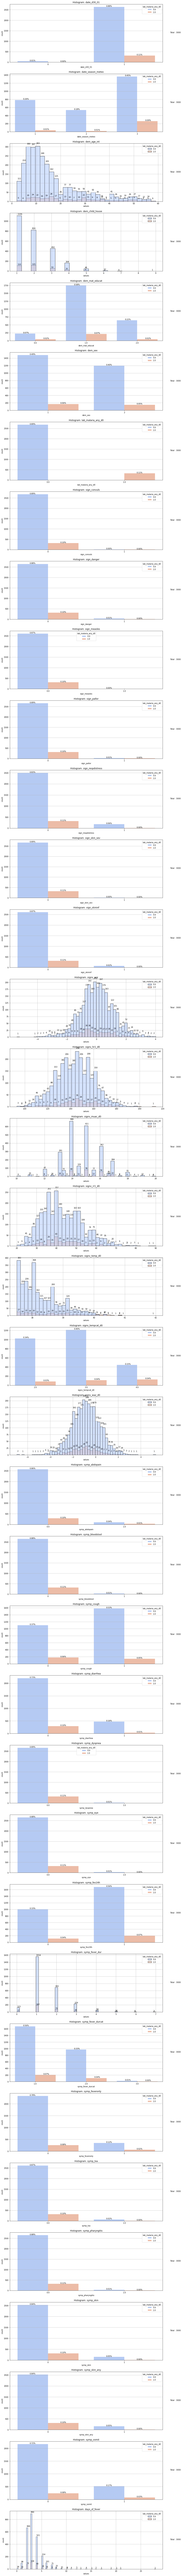

In [69]:
hue="lab_malaria_any_d0"
fig, ax = plt.subplots(figsize=(15,7*len(investigation.columns)), nrows=len(investigation.columns), ncols=1)
for idx, val  in enumerate(investigation.columns):
    total = len(investigation[val])
    ax[idx].set_xlabel("values")
    ax[idx].set_ylabel("count")
    ax[idx].set_title("Histogram: {}".format(val))
    ax[idx].xaxis.grid(True)
    ax[idx].yaxis.grid(True)

    if val not in numerical:
        sns.countplot(data=investigation, ax = ax[idx], x=val, hue = hue, palette = "coolwarm")
    else: 
        sns.histplot(data=investigation, ax = ax[idx], x = val, hue = hue, palette = "coolwarm")

    for patch in ax[idx].patches:
        x = patch.get_xy()[0]
        w = patch.get_width()
        h = patch.get_height()
#         print(idx,val,x,w,h)
        if val not in numerical:
            ax[idx].text(x + w/2.5, h+10, "{:.2f}%".format(h/total))
        else:
            if h !=0: 
                ax[idx].text(x+w/5, h*1.01+10, "{:.0f}".format(h))
    max_x = investigation[val].nunique()
    ax[idx].text(1.05, 0.5, "Total : {:.0f}".format(total),transform=ax[idx].transAxes)


now we should think about removing features which only have 1 unique value, or pretty much just 1 

We will only consider binary variables for this task:
- symp_dyspnea is a good example

if the ratio of unique values is 10 times greater than that of the label we are trying to predict (which is already very imbalanced) then we will drop it  (or if it is 10 times lesser than the inverse of the label's ratio)

In [70]:
label_ratio = temp[temp.name==current_label[0]].ratio.values[0]
features_imbalanced = temp[(temp.ratio>10*label_ratio)|(temp.ratio<1/(10*label_ratio))].name
temp[(temp.ratio>10*label_ratio)|(temp.ratio<1/(10*label_ratio))]

,name,nunique,nnull,%null,min,max,counts,varlab,type,ratio
84,sign_convuls,2,0,0.000000,0.0,1.0,"[3179, 13]",Sign: Convulsion (d0-d3),bin,244.538462
94,sign_measles,2,92,0.028822,0.0,1.0,"[3094, 6]",Sign: Any sign of measles infection (d0-d3),bin,515.666667
95,sign_pallor,2,0,0.000000,0.0,1.0,"[3158, 34]",Sign: Any sign of anemia (d0-d3),bin,92.882353
100,sign_skin_sev,2,0,0.000000,0.0,1.0,"[3182, 10]",Sign: Severe skin or soft tissue infection (d0...,bin,318.200000
123,symp_bloodstool,2,0,0.000000,0.0,1.0,"[3159, 33]",Symptom: Bloody stool (d0-d3),bin,95.727273
129,symp_dyspnea,2,1,0.000313,0.0,1.0,"[3171, 20]",Symptom: Dyspnea,bin,158.550000
132,symp_eye,2,1,0.000313,0.0,1.0,"[3156, 35]",Symptom: Any eye problem (d0-d3),bin,90.171429


In [71]:
investigation = investigation[list(set(investigation.columns)-set(features_imbalanced))]

now let's take a look at correlations between the remaining variables:

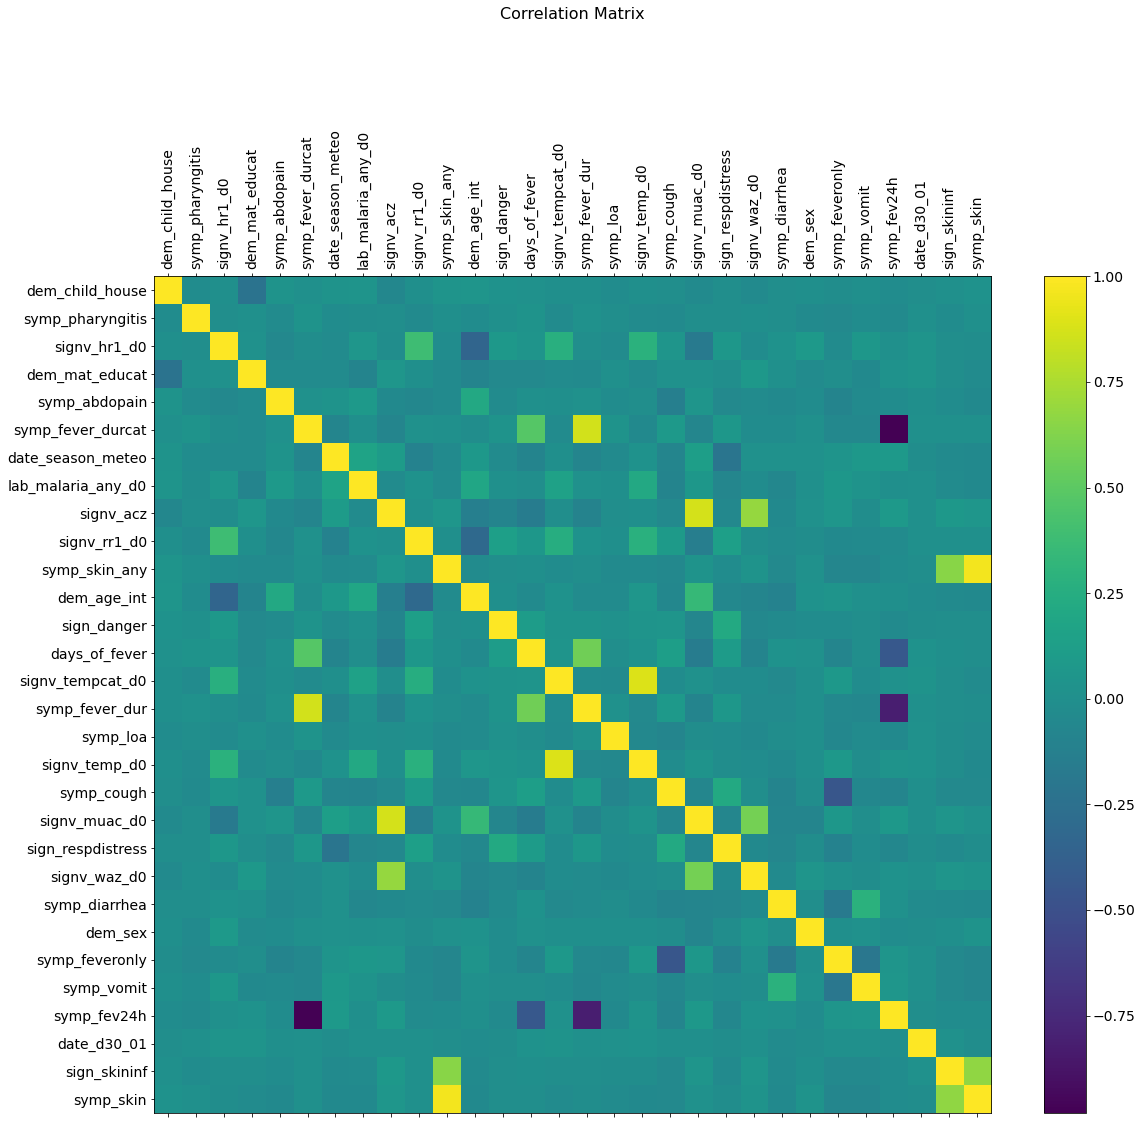

In [72]:
correlation  = investigation.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation, fignum=f.number)
plt.xticks(range(investigation.shape[1]), investigation.columns, fontsize=14, rotation = 90)
plt.yticks(range(investigation.shape[1]), investigation.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, x=0.5, y=1.3)
plt.show()

more precisely, let's take a look at the correlation values that are above an absolute value of 0.5

(this is pearson coefficient correlation)

In [73]:
corr_thr = 0.75
high_corr = [[correlation.columns[x],correlation.columns[y],correlation.iloc[x,y]] for (x,y) in zip(*np.where(np.abs(correlation)>corr_thr)) if x!= y and x>y]
high_corr

[['symp_fever_dur', 'symp_fever_durcat', 0.8667634510956042],
 ['signv_temp_d0', 'signv_tempcat_d0', 0.8991405003053075],
 ['signv_muac_d0', 'signv_acz', 0.874282813872231],
 ['symp_fev24h', 'symp_fever_durcat', -0.9813424458399351],
 ['symp_fev24h', 'symp_fever_dur', -0.8164691650227373],
 ['symp_skin', 'symp_skin_any', 0.9620225758025913]]

from these: we will remove signv_tempcat, symp_skin, symp_fever_durcat, symp_fev24h and signv_aczm

In [74]:
features_correlated = ["signv_tempcat_d0","symp_skin","symp_fever_durcat","symp_fev24h","signv_acz"]

In [75]:
final_features = investigation[list(set(investigation.columns) - set(features_correlated))].columns
list(final_features)

['days_of_fever',
 'dem_child_house',
 'symp_pharyngitis',
 'symp_fever_dur',
 'symp_loa',
 'signv_temp_d0',
 'symp_cough',
 'signv_hr1_d0',
 'signv_muac_d0',
 'sign_respdistress',
 'signv_waz_d0',
 'symp_diarrhea',
 'dem_mat_educat',
 'symp_abdopain',
 'dem_sex',
 'symp_feveronly',
 'symp_vomit',
 'date_season_meteo',
 'lab_malaria_any_d0',
 'signv_rr1_d0',
 'date_d30_01',
 'sign_skininf',
 'symp_skin_any',
 'dem_age_int',
 'sign_danger']

# What about if we run Boruta style method?

# ML

In [76]:
import sklearn
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder, MinMaxScaler

from pprint import pprint
from time import time

## preprocessing pipeline

In [79]:
y_label

['lab_malaria_any_d0']

In [96]:
X_labels=list(set(final_features)-set(y_label))
selected_data = full_data.dropna(subset=y_label)
X=np.array(selected_data[X_labels])
y = np.array(selected_data[y_label]).ravel()


In [95]:
full_data..lab_malaria_any_d0.isnull().sum()

0

In [49]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

['days_of_fever',
 'sign_skininf',
 'dem_child_house',
 'symp_pharyngitis',
 'symp_fever_dur',
 'symp_loa',
 'signv_temp_d0',
 'symp_cough',
 'signv_hr1_d0',
 'signv_muac_d0',
 'sign_respdistress',
 'symp_diarrhea',
 'signv_waz_d0',
 'dem_mat_educat',
 'symp_abdopain',
 'dem_sex',
 'symp_feveronly',
 'symp_vomit',
 'date_season_meteo',
 'signv_rr1_d0',
 'date_d30_01',
 'dem_age_int',
 'symp_skin_any',
 'sign_danger']

In [3]:
def get_feature_type_indices(feature_type, data):
    return [1 if i in feature_type else 0 for i in data.columns]


def create_preprocessing_pipeline(data, numerical, categorical, binary):

    numerical_idx= get_feature_type_indices(numerical, data)
    categorical_idx=get_feature_type_indices(categorical, data)
    binary_idx=get_feature_type_indices(binary, data)

    numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehotencoder', OneHotEncoder(categories="auto")),#handle_unknown="ignore"
    ])
    binary_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ('onehotencoder', OneHotEncoder(categories="auto"))
    ])

    preprocessor = ColumnTransformer(
        transformers = [
            ("num", numerical_transformer, numerical_idx),
            ("cat", categorical_transformer, categorical_idx),
            ("bin", binary_transformer, binary_idx)
        ]
    )
    return preprocessor

In [4]:
preprocessor = create_preprocessing_pipeline(data, numerical, categorical, binary)

NameError: name 'data' is not defined

In [82]:
set_config()
preprocessor


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]), ('cat', Pipeline(memory=None,
    ..., handle_unknown='error',
       n_values=None, sparse=True))]), [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0])])

In [88]:
def run_grid_search_cv(pipeline, parameters, X_train, y_train, cv=5, return_train_score= True, njobs=1, verbose=1):
    grid_search = GridSearchCV(pipeline, parameters, cv=cv)
    print("gridsearch; pipeline: ", [name for name,_ in pipeline.steps])
    pprint(parameters)
    t0=time()
    grid_search.fit(X_train, y_train)
    print("time: {:.3f}".format(time()-t0))
    print("time: {:.3f}".format(grid_search.best_score_))
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    return grid_search

## Bernoulli Naive Bayes

In [117]:
pipeline_BNB = Pipeline([
    ("preprocessor", preprocessor),
    ('clf', BernoulliNB()),
])

parameters_BNB= {
    'clf__alpha':(np.sort(np.append(np.logspace(-10, 10, 21), 
                                    np.linspace(10,1000,19),
                                   ))),
    'clf__fit_prior':(False, True),
}
    


In [118]:
grid_search_BNB = run_grid_search_cv(pipeline_BNB, parameters_BNB, X_train, y_train)

gridsearch; pipeline:  ['preprocessor', 'clf']
{'clf__alpha': array([1.00e-10, 1.00e-09, 1.00e-08, 1.00e-07, 1.00e-06, 1.00e-05,
       1.00e-04, 1.00e-03, 1.00e-02, 1.00e-01, 1.00e+00, 1.00e+01,
       1.00e+01, 6.50e+01, 1.00e+02, 1.20e+02, 1.75e+02, 2.30e+02,
       2.85e+02, 3.40e+02, 3.95e+02, 4.50e+02, 5.05e+02, 5.60e+02,
       6.15e+02, 6.70e+02, 7.25e+02, 7.80e+02, 8.35e+02, 8.90e+02,
       9.45e+02, 1.00e+03, 1.00e+03, 1.00e+04, 1.00e+05, 1.00e+06,
       1.00e+07, 1.00e+08, 1.00e+09, 1.00e+10]),
 'clf__fit_prior': (False, True)}
time: 10.895
time: 0.897
clf__alpha 100000.0
clf__fit_prior True


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

Text(0, 0.5, 'Mean Score')

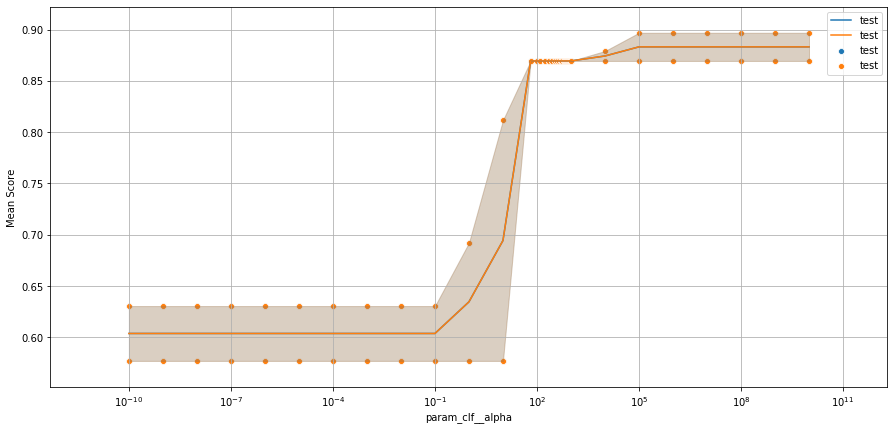

In [119]:
fig, ax = plt.subplots(figsize=(15,7))
results_BNB = pd.DataFrame(grid_search_BNB.cv_results_)
coi = "param_clf__alpha"
plt.grid(True)
ax.set_xscale("log")
sns.scatterplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.scatterplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.lineplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.lineplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
ax.set_ylabel("Mean Score")

#              yerr = plot_results["std_test_score"])